In [49]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML 
import itertools
import networkx as nx
import sys
import matplotlib.pyplot as plt

In [4]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)
sep = '||||'

In [14]:
df = pd.read_csv('data/plays.csv')
df = df.set_index('Dataline')

df['ActSceneLine'] = df[['ActSceneLine']].applymap(lambda x: str(x))
df['Act'] = [ np.nan if line == np.nan else line.split('.')[0] for line in df.ActSceneLine]
df['Scene'] = [ np.nan if line == np.nan else line.split('.')[1] if len(line.split('.')) > 1 else np.nan for line in df.ActSceneLine]

df = df.dropna()

df['Act'] = [int(float(a)) for a in df['Act']]
df['Scene'] = [int(float(s)) for s in df['Scene']]
df['PlayerLinenumber'] = df[['PlayerLinenumber']].applymap(lambda x : round(x))

df['Code'] = ''
for i,r in df.iterrows():
    df.at[i, 'Code'] = r['Play'] + sep + '.'.join([str(r['Act']), str(r['Scene']), '{:03}'.format(r['PlayerLinenumber'])]) + sep + r['Player']

df[df.Play == 'Hamlet']

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Code
Dataline,,,,,,,,
32436,Hamlet,1,1.1.1,BERNARDO,Who's there?,1,1,Hamlet||||1.1.001||||BERNARDO
32437,Hamlet,2,1.1.2,FRANCISCO,"Nay, answer me: stand, and unfold yourself.",1,1,Hamlet||||1.1.002||||FRANCISCO
32438,Hamlet,3,1.1.3,BERNARDO,Long live the king!,1,1,Hamlet||||1.1.003||||BERNARDO
32439,Hamlet,4,1.1.4,FRANCISCO,Bernardo?,1,1,Hamlet||||1.1.004||||FRANCISCO
32440,Hamlet,5,1.1.5,BERNARDO,He.,1,1,Hamlet||||1.1.005||||BERNARDO
32441,Hamlet,6,1.1.6,FRANCISCO,You come most carefully upon your hour.,1,1,Hamlet||||1.1.006||||FRANCISCO
32442,Hamlet,7,1.1.7,BERNARDO,"'Tis now struck twelve, get thee to bed, Franc...",1,1,Hamlet||||1.1.007||||BERNARDO
32443,Hamlet,8,1.1.8,FRANCISCO,"For this relief much thanks: 'tis bitter cold,",1,1,Hamlet||||1.1.008||||FRANCISCO
32444,Hamlet,8,1.1.9,FRANCISCO,And I am sick at heart.,1,1,Hamlet||||1.1.008||||FRANCISCO


In [7]:
def make_relationship(a, b):
    return sep.join(sorted([a, b]))

In [39]:
m = df[['Code', 'PlayerLine']].groupby(['Code']).agg(lambda x: sep.join(x))
m = m.reset_index()

m['Play'] = [c.split(sep)[0] for c in m['Code']]
m['Address'] = [c.split(sep)[1] for c in m['Code']]
m['Act'] = [a.split('.')[0] for a in m['Address']]
m['Scene'] = [a.split('.')[1] for a in m['Address']]

m['Player'] = [c.split(sep)[2].title() for c in m['Code']]
m['Player'] = [' '.join(p.split()) for p in m['Player']]


m['Relationship'] = m['Target'] = ''

# fill targ 
for i, r in m.iterrows():
    line_number = int(r['Address'].split('.')[-1])
    is_first_line = line_number == 1
    is_last_line = i + 1 >= len(m) or m.at[i + 1, 'Act'] != r['Act'] or m.at[i + 1, 'Scene'] != r['Scene']
    
    if not is_first_line and not is_last_line:
        prev = m.at[i - 1, 'Player']
        next = m.at[i + 1, 'Player']
        r['Target'] = prev if prev == next else ''
        r['Relationship'] = '' if r['Target'] == '' else  make_relationship(r['Player'], r['Target'])
    
m = m.applymap(lambda x: x if x else np.NaN )



m

,Code,PlayerLine,Play,Address,Act,Scene,Player,Relationship,Target
0,A Comedy of Errors||||1.1.001||||AEGEON,"Proceed, Solinus, to procure my fall||||And by...",A Comedy of Errors,1.1.001,1,1,Aegeon,NaN,NaN
1,A Comedy of Errors||||1.1.002||||DUKE SOLINUS,"Merchant of Syracuse, plead no more,||||I am n...",A Comedy of Errors,1.1.002,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
2,A Comedy of Errors||||1.1.003||||AEGEON,"Yet this my comfort: when your words are done,...",A Comedy of Errors,1.1.003,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
3,A Comedy of Errors||||1.1.004||||DUKE SOLINUS,"Well, Syracusian, say in brief the cause||||Wh...",A Comedy of Errors,1.1.004,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
4,A Comedy of Errors||||1.1.005||||AEGEON,A heavier task could not have been imposed||||...,A Comedy of Errors,1.1.005,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
5,A Comedy of Errors||||1.1.006||||DUKE SOLINUS,"Nay, forward, old man, do not break off so,|||...",A Comedy of Errors,1.1.006,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
6,A Comedy of Errors||||1.1.007||||AEGEON,"O, had the gods done so, I had not now||||Wort...",A Comedy of Errors,1.1.007,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
7,A Comedy of Errors||||1.1.008||||DUKE SOLINUS,"And for the sake of them thou sorrowest for,||...",A Comedy of Errors,1.1.008,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
8,A Comedy of Errors||||1.1.009||||AEGEON,"My youngest boy, and yet my eldest care,||||At...",A Comedy of Errors,1.1.009,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
9,A Comedy of Errors||||1.1.010||||DUKE SOLINUS,"Hapless AEgeon, whom the fates have mark'd||||...",A Comedy of Errors,1.1.010,1,1,Duke Solinus,NaN,NaN


In [47]:
def extract_matrix(play):
    players = sorted(m[m.Play == play].Player.unique())
    players = [p for p in players if p not in ['All', 'Prologue']]
    
    d = {player: [0] * len(players) for player in players}
    
    matrix = pd.DataFrame(data=d, index=players)
        
    for relationship in itertools.combinations(players, 2):
        r = make_relationship(relationship[0], relationship[1])
        cnt = len(m[m.Relationship == r])
        matrix.at[relationship[1], relationship[0]] = matrix.at[relationship[0], relationship[1]] = cnt

    #diag            
    for p in players:
        matrix.at[p, p] = -99        
    
    return matrix    

In [44]:
extract_matrix('Romeo and Juliet')

,Abraham,Apothecary,Balthasar,Benvolio,Capulet,Chorus,First Citizen,First Musician,First Servant,First Watchman,Friar John,Friar Laurence,Gregory,Juliet,Lady Capulet,Lady Montague,Mercutio,Montague,Musician,Nurse,Page,Paris,Peter,Prince,Richmond,Romeo,Sampson,Second Capulet,Second Musician,Second Servant,Second Watchman,Servant,Third Musician,Third Watchman,Tybalt
Abraham,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
Apothecary,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0
Balthasar,0,0,-99,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0
Benvolio,0,0,0,-99,0,0,2,0,0,0,0,0,0,0,0,1,33,7,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,2
Capulet,0,0,0,0,-99,0,0,0,1,0,0,3,0,5,7,0,0,1,0,10,0,6,0,0,0,0,0,3,0,4,0,0,0,0,9
Chorus,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Citizen,0,0,0,2,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Musician,0,0,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0
First Servant,0,0,0,0,1,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0
First Watchman,0,0,0,0,0,0,0,0,0,-99,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,0,2,0


In [45]:
extract_matrix('Hamlet')

,Bernardo,Captain,Danes,First Ambassador,First Clown,First Player,First Priest,First Sailor,Francisco,Gentleman,Ghost,Guildenstern,Hamlet,Horatio,King Claudius,Laertes,Lord,Lord Polonius,Lucianus,Marcellus,Messenger,Ophelia,Osric,Player King,Player Queen,Prince Fortinbras,Queen Gertrude,Reynaldo,Rosencrantz,Second Clown,Servant,Voltimand
Bernardo,-99,0,0,0,0,0,0,0,10,0,0,0,5,7,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
Captain,0,-99,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Danes,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Ambassador,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Clown,0,0,0,0,-99,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0
First Player,0,0,0,0,0,-99,0,0,0,0,0,0,8,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Priest,0,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Sailor,0,0,0,0,0,0,0,-99,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Francisco,10,0,0,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
Gentleman,0,0,0,0,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


In [46]:
extract_matrix('A Midsummer nights dream')

,Bottom,Cobweb,Demetrius,Egeus,Fairy,Flute,Helena,Hermia,Hernia,Hippolyta,Lion,Lysander,Moonshine,Moth,Mustardseed,Oberon,Peaseblossom,Philostrate,Puck,Pyramus,Quince,Snout,Snug,Starveling,Theseus,Thisbe,Titania,Wall
Bottom,-99,2,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,0,0,34,2,0,0,0,0,12,0
Cobweb,2,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Demetrius,0,0,-99,0,0,0,13,9,0,0,0,9,0,0,0,0,0,0,5,0,0,0,0,0,3,0,0,0
Egeus,0,0,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0
Fairy,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
Flute,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,1,0,0,0,0,0
Helena,0,0,13,0,0,0,-99,20,1,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hermia,0,0,9,0,0,0,20,-99,0,0,0,27,0,0,0,0,0,0,1,0,0,0,0,0,7,0,0,0
Hernia,0,0,0,0,0,0,1,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hippolyta,0,0,0,0,0,0,0,0,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0


In [13]:
m.Play.unique()

array(['A Comedy of Errors', 'A Midsummer nights dream', 'A Winters Tale',
       'Alls well that ends well', 'Antony and Cleopatra',
       'As you like it', 'Coriolanus', 'Cymbeline', 'Hamlet', 'Henry IV',
       'Henry VI Part 1', 'Henry VI Part 2', 'Henry VI Part 3',
       'Henry VIII', 'Henry V', 'Julius Caesar', 'King John', 'King Lear',
       'Loves Labours Lost', 'Measure for measure', 'Merchant of Venice',
       'Merry Wives of Windsor', 'Much Ado about nothing', 'Othello',
       'Pericles', 'Richard III', 'Richard II', 'Romeo and Juliet',
       'Taming of the Shrew', 'The Tempest', 'Timon of Athens',
       'Titus Andronicus', 'Troilus and Cressida', 'Twelfth Night',
       'Two Gentlemen of Verona', 'macbeth'], dtype=object)

------------------

In [354]:
def plot_matrix(mat):
    _, __ = plt.subplots(1, 1, figsize=(24, 18))
    g = nx.Graph()
    
    for comb in itertools.combinations(mat.columns, 2):
        if mat.loc[comb[0], comb[1]] > 0:
            g.add_edge(comb[0], comb[1], weight=0.6)        
       
    pos = nx.spring_layout(g, k=1.9)    
    degrees = nx.degree(g)

    nx.draw_networkx_edges(g, pos, width=0.5, alpha=0.5)    
    nx.draw_networkx_labels(g, pos, font_size=13, font_family='sans-serif')        
    nx.draw(g, pos, nodelist=[d[0] for d in degrees], node_size=[d[1] * 1500 for d in degrees], node_color=range(len(g.nodes)), cmap=plt.cm.Blues)
    
    plt.axis('off')
    plt.show()                

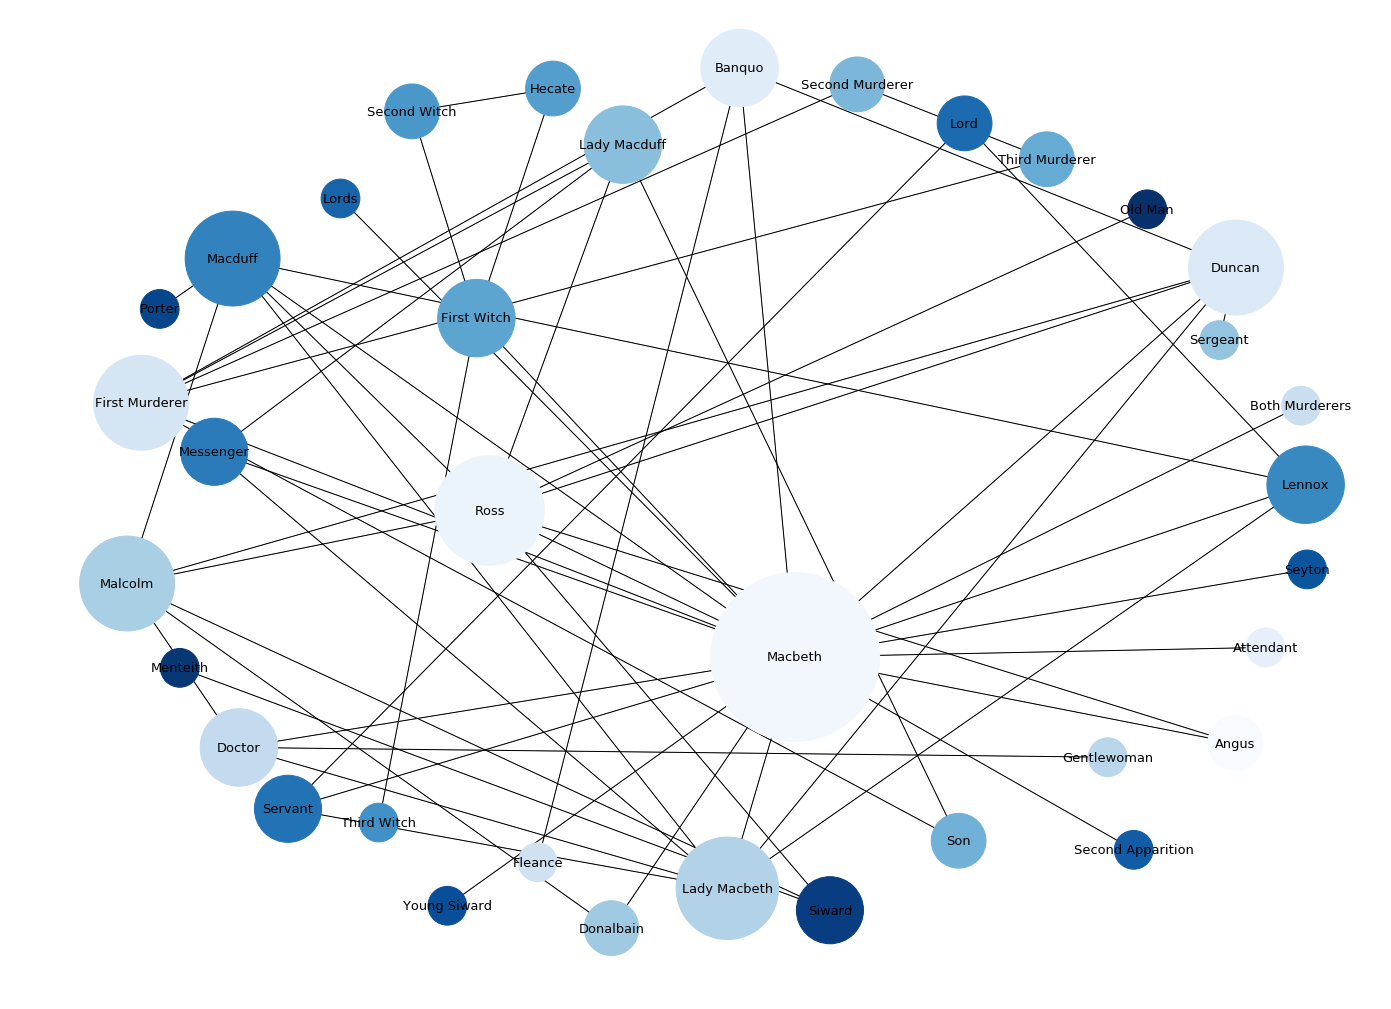

In [357]:
plot_matrix(extract_matrix('macbeth'))